In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.ops.math_ops import reduce_prod

# Corrected import statement for TextVectorization
from tensorflow.keras.layers import TextVectorization

# Corrected import statement for Embedding
from tensorflow.keras.layers import Embedding


In [ ]:
jobs_file = tf.keras.utils.get_file(
    fname="./fraudulent_jobs.csv",
    origin="https://uofi.box.com/shared/static/sfw0eqvj7q49vmexpztqke7xzhspevnb.csv"
)

df=pd.read_csv(jobs_file)

df.head()

50061601/50061601 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#drop jobs_id column and update 'work_remote' to 'work_remote's
df.drop(columns=['job_id'], inplace=True)
df.rename(columns={'telecommuting': 'work_remote'}, inplace=True)
df.columns



Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'work_remote',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   work_remote          17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [ ]:

df.nunique()

,0
title,11231
location,3105
department,1337
salary_range,874
company_profile,1709
description,14801
requirements,11967
benefits,6204
work_remote,2
has_company_logo,2


In [ ]:

df.isna().sum()

,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [ ]:

df['fraudulent'].value_counts()


,count
fraudulent,
0,17014
1,866


In [ ]:

text_cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
numeric_cols = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
col_to_predict = ['fraudulent']


In [ ]:
def move_column(df, col):
  df['Temp_Col'] = df[col]
  df.drop(columns=[col], inplace=True)
  df.rename(columns={'Temp_Col': col}, inplace=True)
  return df

In [ ]:

df['employment_type'].fillna('No Data', inplace=True)
df['required_experience'].fillna('No Data', inplace=True)
df['required_education'].fillna('No Data', inplace=True)
df['industry'].fillna('No Data', inplace=True)
df['function'].fillna('No Data', inplace=True)


In [ ]:

df.isna().sum()

,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [ ]:

df.notna().sum()

,0
title,17880
location,17534
department,6333
salary_range,2868
company_profile,14572
description,17879
requirements,15184
benefits,10668
work_remote,17880
has_company_logo,17880


In [ ]:
df[df['description'].isna()] #only 1 row with an empty description -- the post only has title and location and it is a fraud post --> keeping it


,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17513,Office Manager,"PL, MZ, Warsaw",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,No Data,No Data,No Data,No Data,No Data,1


In [ ]:
#rows that are entirely null in the text columns
null_text = df[(df['location'].isna()) & (df['department'].isna()) & (df['company_profile'].isna()) & (df['requirements'].isna()) & (df['benefits'].isna())]
# 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'
print(f"There are {null_text.shape[0]} rows where all text columns aside from 'title' and 'description' are empty. Of these rows, {null_text['fraudulent'].sum()} are fraudulent posts.")


There are 19 rows where all text columns aside from 'title' and 'description' are empty. Of these rows, 12 are fraudulent posts.


In [ ]:
for col in text_cols:
  df[col].fillna(value=" ", inplace=True)
  print(f"Max length of '{col}': {df[col].map(len).max()}") #get maximum number of characters in each column


Max length of 'title': 142
Max length of 'location': 161
Max length of 'department': 255
Max length of 'company_profile': 6178
Max length of 'description': 14907
Max length of 'requirements': 10864
Max length of 'benefits': 4429


In [ ]:

df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']
df['full_text'][0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [ ]:

print(f"Min length of 'full text': {df['full_text'].map(len).min()}")
print(f"Max length of 'full text': {df['full_text'].map(len).max()}")

Min length of 'full text': 33
Max length of 'full text': 14964


In [ ]:
def update_text(new_df):
  new_df['full_text'] = new_df['full_text'].str.replace(pat='US', repl='USA', case=True)
  new_df['location'] = new_df['location'].str.replace(pat='US', repl='USA', case=True)
  return new_df

In [ ]:

df = update_text(df)


In [ ]:

def space_words(all_text):
  import re

  result = re.sub('(?<=[A-Za-z])(?=[A-Z][a-z])', '~', all_text)
  result = re.split('~', result)
  result = ' '.join(result)
  all_text = result

  return all_text

In [ ]:
texts = ['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'full_text']

for col in texts:
  df[col] = df[col].apply(space_words)

In [ ]:

df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text
0,Marketing Intern,"USA, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,No Data,No Data,Marketing,0,"Marketing Intern USA, NY, New York Marketing W..."


In [ ]:
def get_unique_words(new_df, col):
  unique_words = []
  idx = list(new_df.index.values)
  for i in idx:
    x = list(new_df[col][i].split())
    unique_words += x
  return unique_words

In [ ]:
for col in texts:
  print(f'Number of total words in {col}: {len(get_unique_words(df, col))}')
  print(f'Number of unique words in {col}: {len(set(get_unique_words(df, col)))}\n')

Number of total words in title: 67673
Number of unique words in title: 7819

Number of total words in location: 55748
Number of unique words in location: 2713

Number of total words in department: 8883
Number of unique words in department: 1218

Number of total words in company_profile: 1668791
Number of unique words in company_profile: 28263

Number of total words in description: 3110058
Number of unique words in description: 127256

Number of total words in requirements: 1457315
Number of unique words in requirements: 85515

Number of total words in benefits: 553942
Number of unique words in benefits: 27944

Number of total words in employment_type: 21351
Number of unique words in employment_type: 7

Number of total words in required_experience: 32552
Number of unique words in required_experience: 11

Number of total words in required_education: 38486
Number of unique words in required_education: 22

Number of total words in industry: 39744
Number of unique words in industry: 193

Nu

In [ ]:
salary_df = df['salary_range'].str.split(pat='-', n=-1, expand=True) #separate salary range into two columns
salary_df[0].unique()[90:100] #months (strings) are included as salaries due to csv interpretation of the salary range


array(['96000', '1050', '400000', 'Oct', '800000', '335000', '960000',
       '55', '480000', '24900'], dtype=object)

In [ ]:

months_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

for i in range(salary_df[0].shape[0]):
  if salary_df[0][i] in months_to_int.keys():
    salary_df[0][i] = months_to_int[salary_df[0][i]]

for i in range(salary_df[1].shape[0]):
  if salary_df[1][i] in months_to_int.keys():
    salary_df[1][i] = months_to_int[salary_df[1][i]]

In [ ]:

salary_df[0].unique()[90:100]


array(['96000', '1050', '400000', 10, '800000', '335000', '960000', '55',
       '480000', '24900'], dtype=object)

In [ ]:
salary_df.fillna(value=-1, inplace=True)
salary_df[0] = np.array(salary_df[0], dtype='int64')
salary_df[1] = np.array(salary_df[1], dtype='int64')

df['salary_low'] = salary_df[0]
df['salary_high'] = salary_df[1]
df.drop(columns=['salary_range'], inplace=True)

df['salary_low'].replace(-1, np.nan, inplace=True)
df['salary_high'].replace(-1, np.nan, inplace=True)

df['salary_low'] = df['salary_low'].astype('Int64')
df['salary_high'] = df['salary_high'].astype('Int64')


In [ ]:
df[df['salary_low'].notnull() & df['salary_high'].notnull()][:3] #some examples showing that the salary was converted back to an int value


,title,location,department,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text,salary_low,salary_high
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,"Head of Content (m/f) DE, BE, Berlin ANDROIDPI...",20000,28000
10,ASP.net Developer Job opportunity at United St...,"USA, NJ, Jersey City",,,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - Full Bonus Eligible - Yes Interview...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0,ASP.net Developer Job opportunity at United St...,100000,120000
15,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",0,1,1,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0,"VP of Sales - Vault Dragon SG, 01, Singapore S...",120000,150000


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

print('dataframe shape:',df.shape)

train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
print("train shape:",train.shape)
print('test shape:',test_x.shape)

train_x, val_x = train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)


dataframe shape: (17880, 19)
train shape: (14304, 19)
test shape: (3576, 19)
train_x shape: (11443, 19)
val shape: (2861, 19)


In [ ]:
train_x['employment_type'].isna().sum()

0

In [ ]:

numeric_columns = train_x.select_dtypes(include=[np.number])

grouped_mean = numeric_columns.groupby(train_x['employment_type']).mean()

print(grouped_mean)


                 work_remote  has_company_logo  has_questions  fraudulent  \
employment_type                                                             
Contract            0.086207          0.830629       0.653144    0.032454   
Full-time           0.039903          0.800485       0.464546    0.041116   
No Data             0.037387          0.745045       0.480631    0.068468   
Other               0.051948          0.805195       0.649351    0.064935   
Part-time           0.058939          0.785855       0.495088    0.104126   
Temporary           0.012821          0.865385       0.512821    0.012821   

                    salary_low     salary_high  
employment_type                                 
Contract          35562.509091    55320.754545  
Full-time        886959.068414  1397585.145234  
No Data           51559.694444    81863.083333  
Other             18826.555556   335284.444444  
Part-time         15085.763889    27513.916667  
Temporary         14091.304348    17356.

In [ ]:
salary_means = {}
employment_types = list(train_x['employment_type'].unique())
employment_types.sort()
employment_types

['Contract', 'Full-time', 'No Data', 'Other', 'Part-time', 'Temporary']

In [ ]:
low_means = list(train_x.groupby('employment_type')['salary_low'].mean())
high_means = list(train_x.groupby('employment_type')['salary_high'].mean())
salary_means = {}
for i in range(len(employment_types)):
  salary_means[employment_types[i]] = [int(low_means[i]), int(high_means[i])]

print("List of Means (from train_x dataset):", salary_means)


List of Means (from train_x dataset): {'Contract': [35562, 55320], 'Full-time': [886959, 1397585], 'No Data': [51559, 81863], 'Other': [18826, 335284], 'Part-time': [15085, 27513], 'Temporary': [14091, 17356]}


In [ ]:
for et in employment_types:
    temp = df[df['employment_type'] == et] #separate the group
    temp['salary_low'].fillna(salary_means[et][0], inplace=True)
    temp['salary_high'].fillna(salary_means[et][1], inplace=True)
    df.update(temp, overwrite=False)

df['salary_low'] = df['salary_low'].astype('int64')
df['salary_high'] = df['salary_high'].astype('int64')
print(df.shape)
df.isna().sum()


<ipython-input-40-8aa2c0cc928c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-40-8aa2c0cc928c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_high'].fillna(salary_means[et][1], inplace=True)
<ipython-input-40-8aa2c0cc928c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-inp

(17880, 19)


<ipython-input-40-8aa2c0cc928c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-40-8aa2c0cc928c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_high'].fillna(salary_means[et][1], inplace=True)


,0
title,0
location,0
department,0
company_profile,0
description,0
requirements,0
benefits,0
work_remote,0
has_company_logo,0
has_questions,0


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   work_remote          17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      17880 non-null  object
 11  required_experience  17880 non-null  object
 12  required_education   17880 non-null  object
 13  industry             17880 non-null  object
 14  function             17880 non-null  object
 15  fraudulent           17880 non-null  int64 
 16  full

In [ ]:
df_preproc_done = df.copy()
df_preproc_done.columns


Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'work_remote', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'full_text',
       'salary_low', 'salary_high'],
      dtype='object')

In [ ]:

df['title'] = df['full_text']
df.drop(columns=['location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'full_text'], inplace=True)
df.rename(columns={'title': 'full_text'}, inplace=True)

df = move_column(df, 'fraudulent')
df.head(1)

,full_text,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_low,salary_high,fraudulent
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,Other,Internship,No Data,No Data,Marketing,18826,335284,0


In [ ]:

df['fraudulent'].value_counts()

,count
fraudulent,
0,17014
1,866


In [ ]:

real_df = df[df['fraudulent'] == 0]
fraud_df = df[df['fraudulent'] == 1]

In [ ]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17014 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            17014 non-null  object
 1   work_remote          17014 non-null  int64 
 2   has_company_logo     17014 non-null  int64 
 3   has_questions        17014 non-null  int64 
 4   employment_type      17014 non-null  object
 5   required_experience  17014 non-null  object
 6   required_education   17014 non-null  object
 7   industry             17014 non-null  object
 8   function             17014 non-null  object
 9   salary_low           17014 non-null  int64 
 10  salary_high          17014 non-null  int64 
 11  fraudulent           17014 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.7+ MB


In [ ]:

fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 98 to 17831
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            866 non-null    object
 1   work_remote          866 non-null    int64 
 2   has_company_logo     866 non-null    int64 
 3   has_questions        866 non-null    int64 
 4   employment_type      866 non-null    object
 5   required_experience  866 non-null    object
 6   required_education   866 non-null    object
 7   industry             866 non-null    object
 8   function             866 non-null    object
 9   salary_low           866 non-null    int64 
 10  salary_high          866 non-null    int64 
 11  fraudulent           866 non-null    int64 
dtypes: int64(6), object(6)
memory usage: 88.0+ KB


In [ ]:

print("Min and Max Lengths of 'full_text' in train, val, test ----")
print(f"train - min: {train_x['full_text'].map(len).min()}, max: {train_x['full_text'].map(len).max()}")
print(f"val - min: {val_x['full_text'].map(len).min()}, max: {val_x['full_text'].map(len).max()}")
print(f"test - min: {test_x['full_text'].map(len).min()}, max: {test_x['full_text'].map(len).max()}")

Min and Max Lengths of 'full_text' in train, val, test ----
train - min: 47, max: 13533
val - min: 39, max: 10883
test - min: 33, max: 14968


In [ ]:
import collections
from collections import Counter
import seaborn as sns

<ipython-input-50-7908b7c66d1f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='hls')


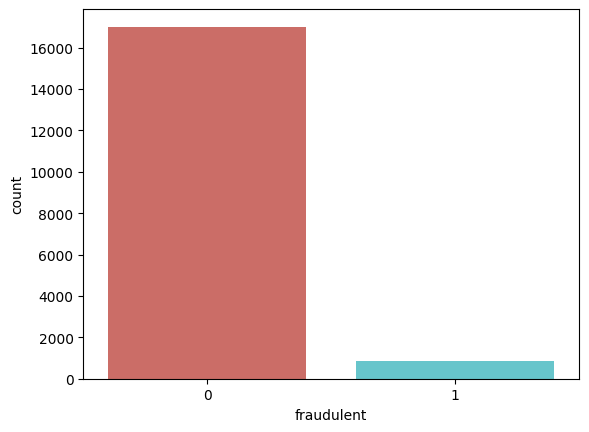

In [ ]:

sns.countplot(x='fraudulent', data=df, palette='hls')
plt.show()


In [ ]:

df['employment_type'].value_counts()

,count
employment_type,
Full-time,11620
No Data,3471
Contract,1524
Part-time,797
Temporary,241
Other,227


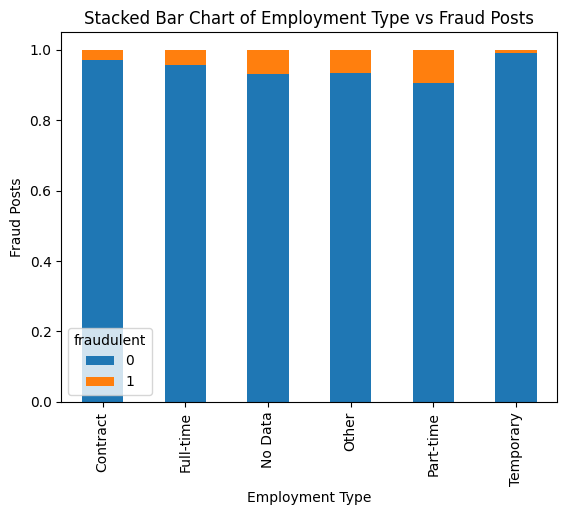

In [ ]:
table=pd.crosstab(df.employment_type, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Employment Type vs Fraud Posts')
plt.xlabel('Employment Type')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:

df['required_experience'].value_counts()

,count
required_experience,
No Data,7050
Mid-Senior level,3809
Entry level,2697
Associate,2297
Not Applicable,1116
Director,389
Internship,381
Executive,141


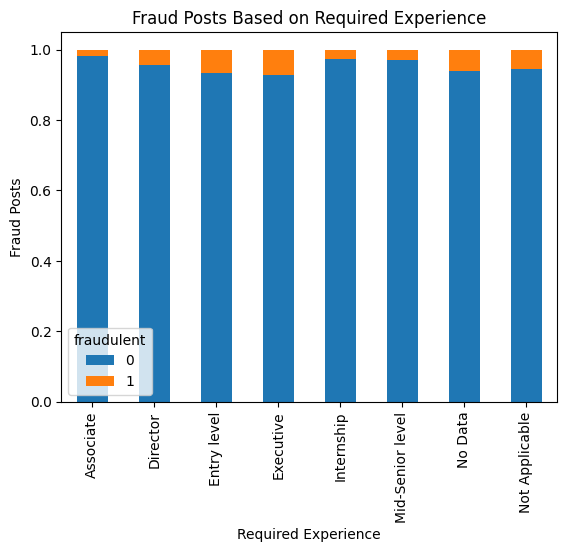

In [ ]:

%matplotlib inline

table=pd.crosstab(df.required_experience, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Fraud Posts Based on Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df['required_education'].value_counts()

,count
required_education,
No Data,8105
Bachelor's Degree,5145
High School or equivalent,2080
Unspecified,1397
Master's Degree,416
Associate Degree,274
Certification,170
Some College Coursework Completed,102
Professional,74


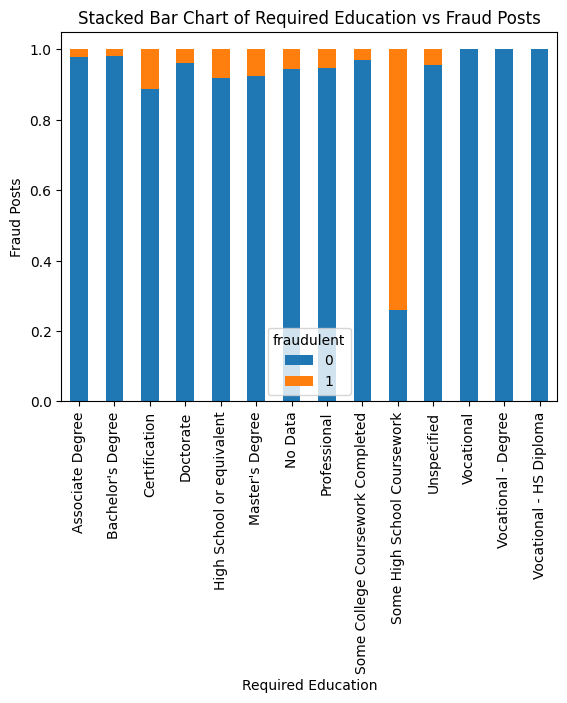

In [ ]:

table=pd.crosstab(df.required_education, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Required Education vs Fraud Posts')
plt.xlabel('Required Education')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df[(df['required_education'] == 'Some High School Coursework') & (df['fraudulent'] == 1)].shape[0] #20 fraud posts out of 27 total posts


20

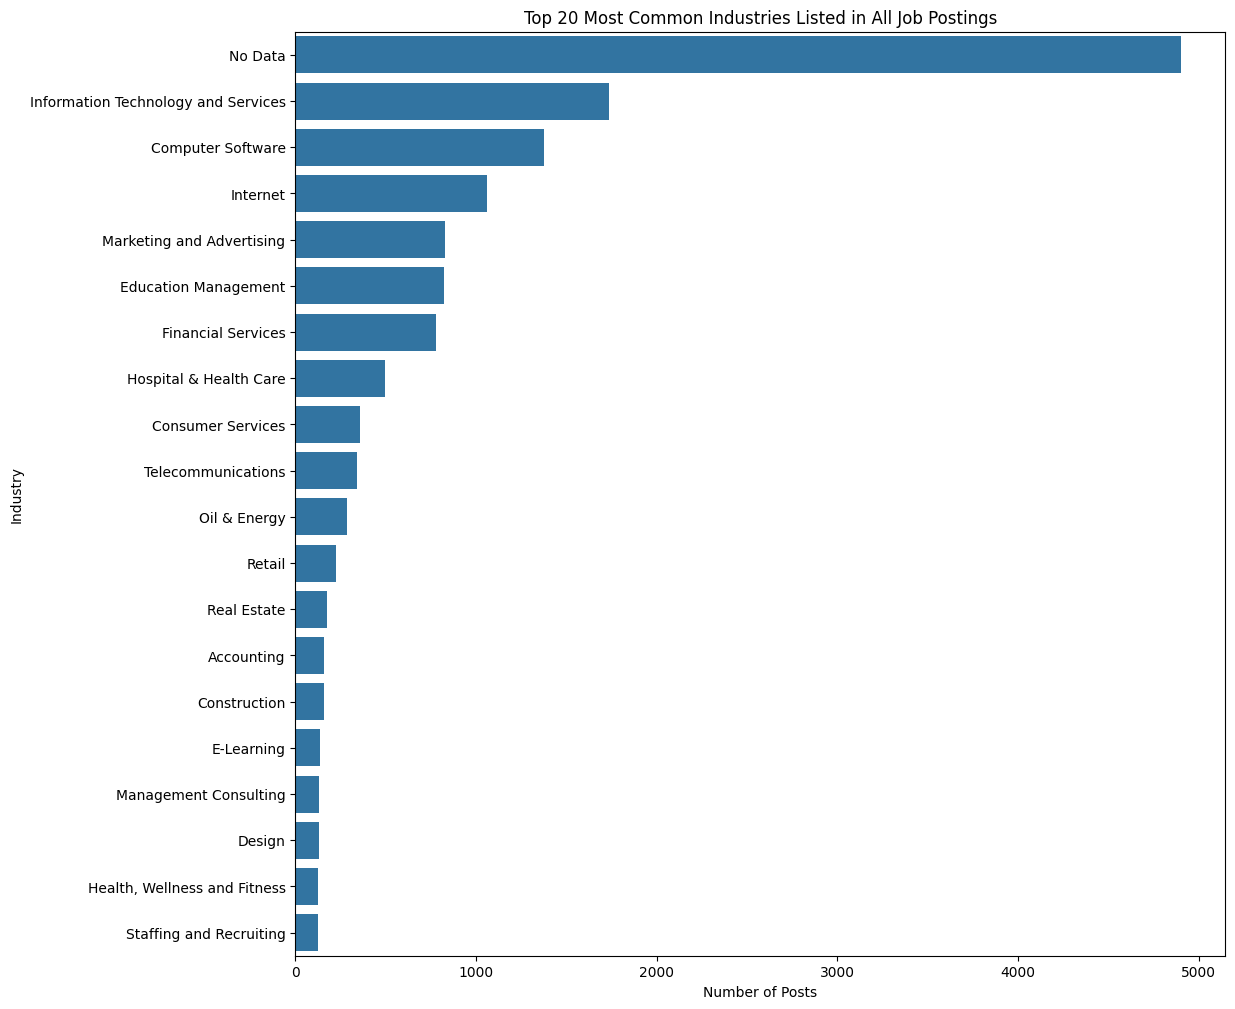

In [ ]:

industry=list(df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in All Job Postings")
plt.show()


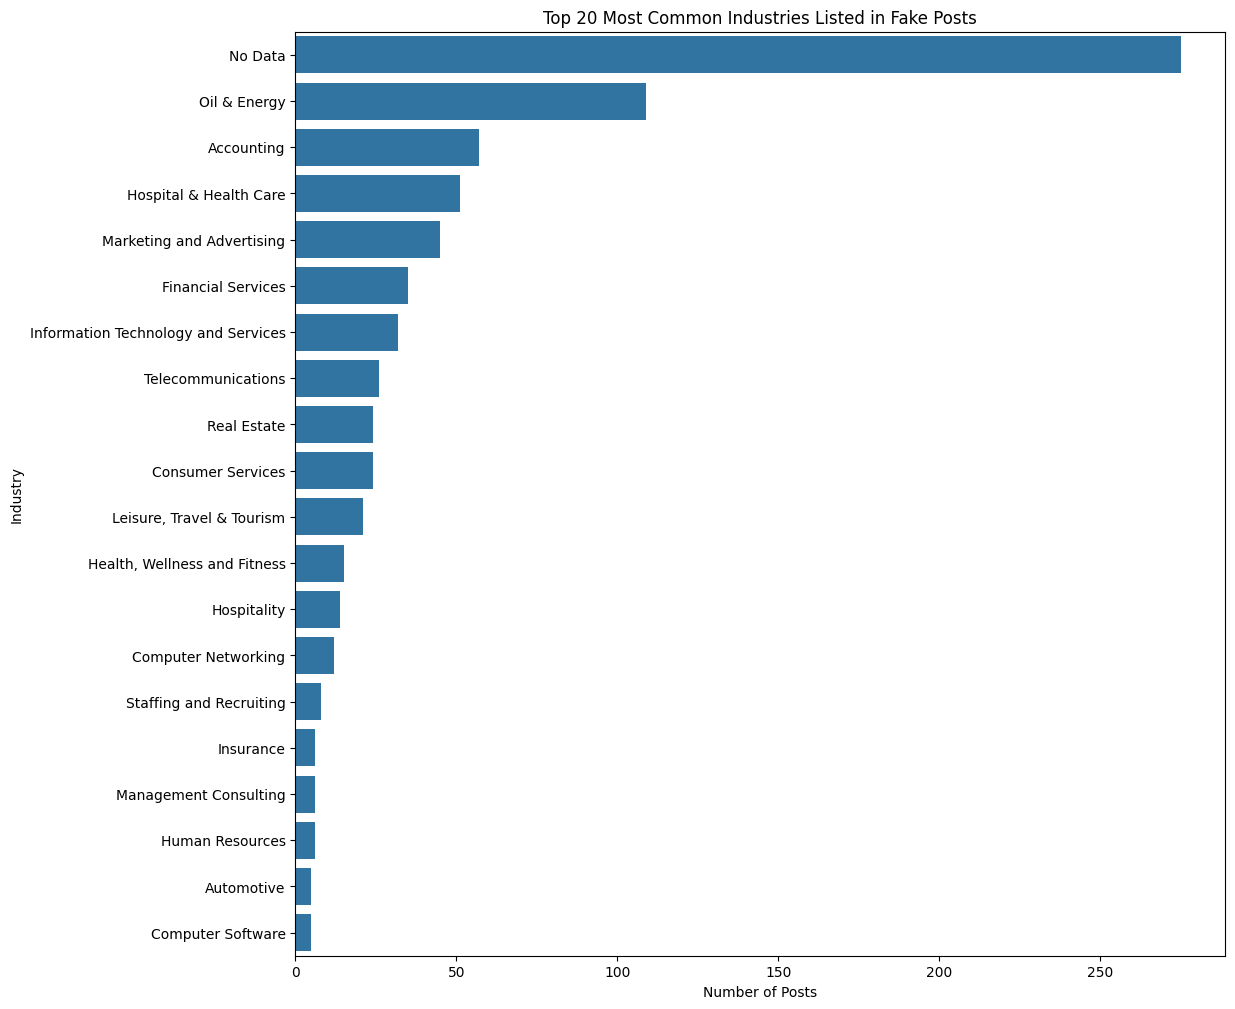

In [ ]:

industry=list(fraud_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Fake Posts")
plt.show()


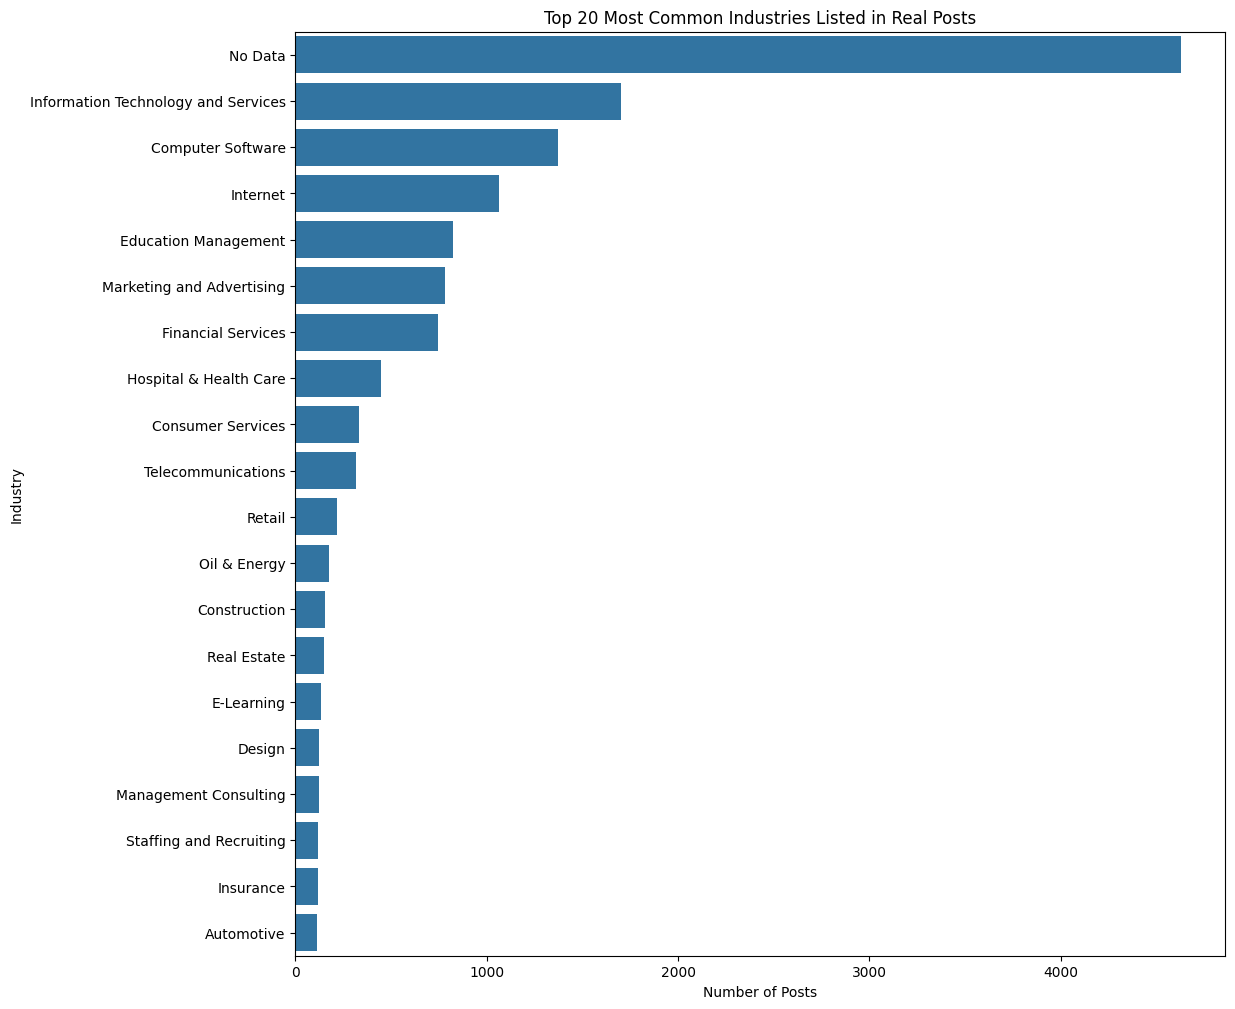

In [ ]:

industry=list(real_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Real Posts")
plt.show()


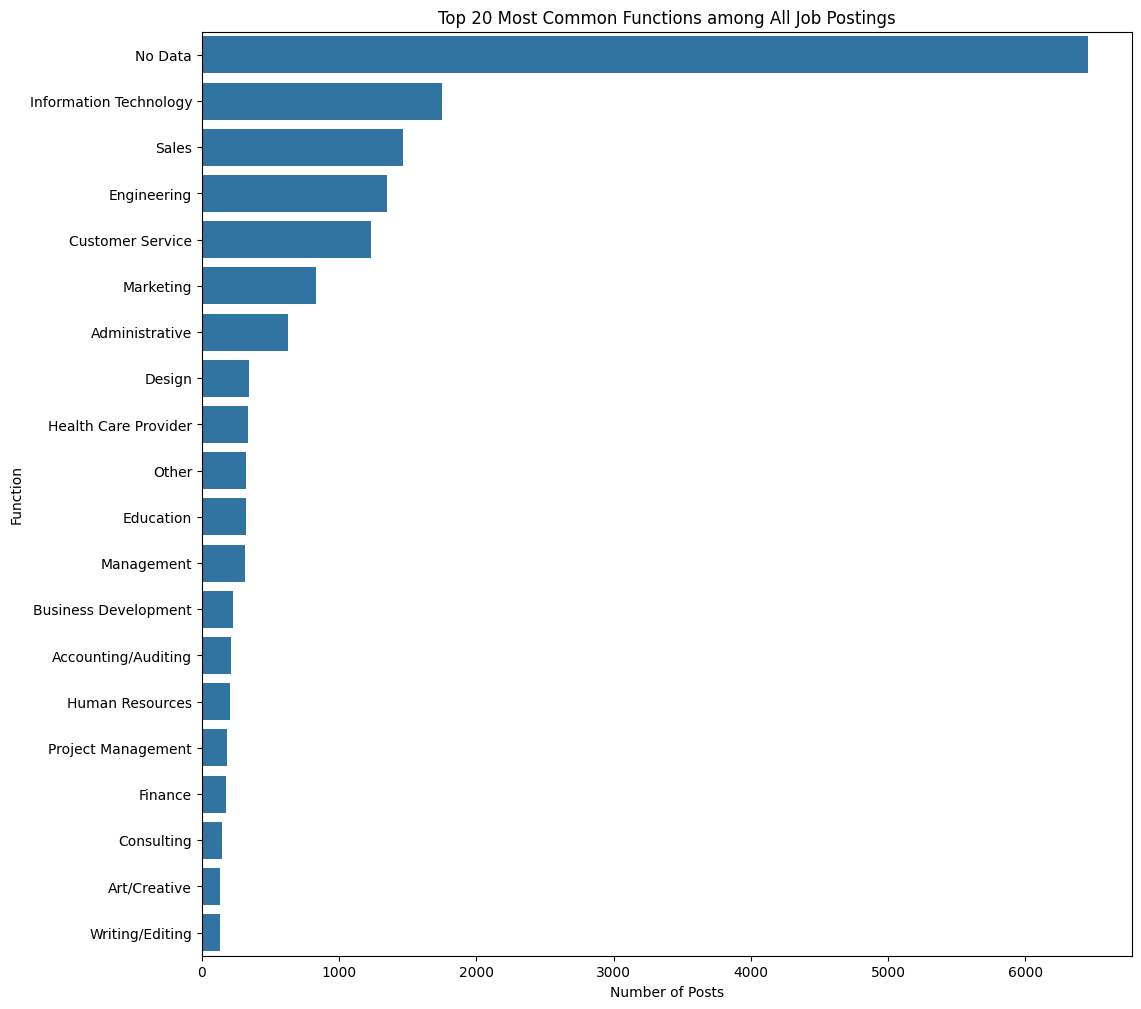

In [ ]:

function=list(df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions among All Job Postings')
plt.show()


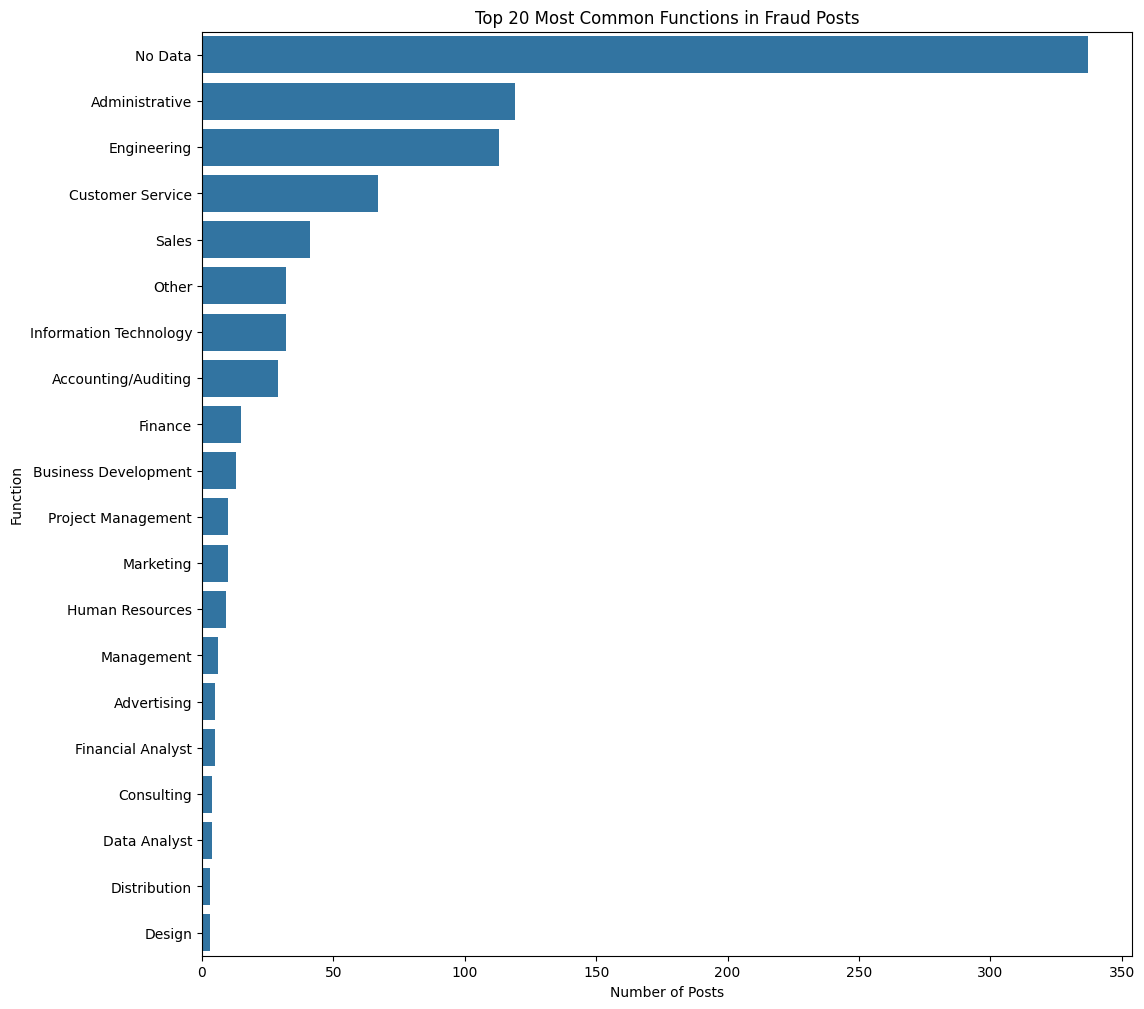

In [ ]:

function=list(fraud_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Fraud Posts')
plt.show()


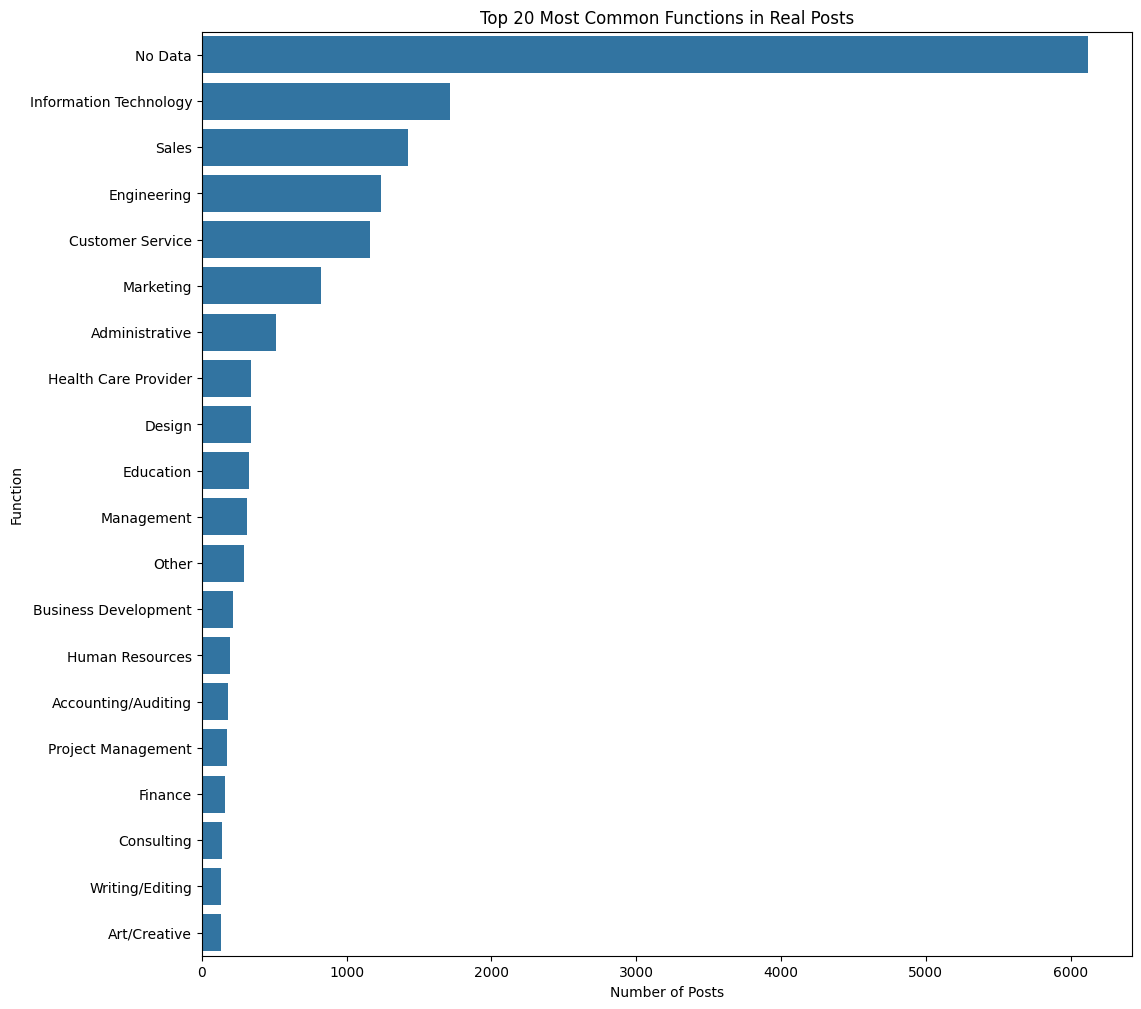

In [ ]:

function=list(real_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Real Posts')
plt.show()


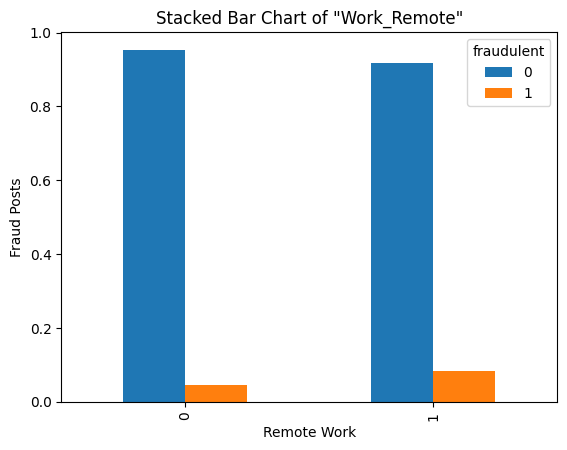

In [ ]:

table=pd.crosstab(df.work_remote, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Work_Remote"')
plt.xlabel('Remote Work')
plt.ylabel('Fraud Posts')
plt.show()

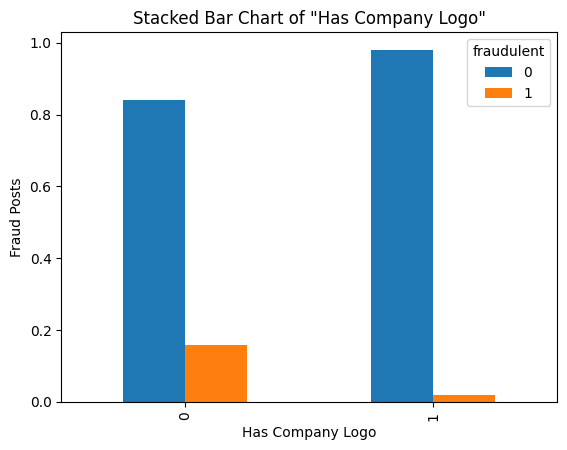

In [ ]:
table=pd.crosstab(df.has_company_logo, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Company Logo"')
plt.xlabel('Has Company Logo')
plt.ylabel('Fraud Posts')
plt.show()

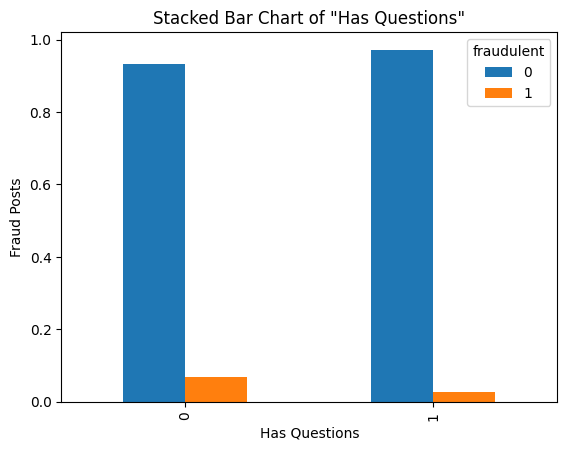

In [ ]:
table=pd.crosstab(df.has_questions, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Questions"')
plt.xlabel('Has Questions')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:

print("Shape before one-hot-encoding:", df.shape)

Shape before one-hot-encoding: (17880, 12)


In [ ]:

df = pd.get_dummies(df, columns=['employment_type', 'required_experience', 'required_education', 'industry', 'function']) #categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
print('Shape after one-hot-encoding:',df.shape) #(17880, 205)
df.head(1)

Shape after one-hot-encoding: (17880, 205)


,full_text,work_remote,has_company_logo,has_questions,salary_low,salary_high,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_No Data,...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,18826,335284,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:

print('dataframe shape:',df.shape)
train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
# print("train shape:",train.shape)

train_x, val_x= train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)
print('test shape:',test_x.shape)

dataframe shape: (17880, 205)
train_x shape: (11443, 205)
val shape: (2861, 205)
test shape: (3576, 205)


In [ ]:
train_x.nunique()

,0
full_text,11281
work_remote,2
has_company_logo,2
has_questions,2
salary_low,206
...,...
function_Science,2
function_Strategy/Planning,2
function_Supply Chain,2
function_Training,2


In [ ]:

train_x.nunique()[:41]

,0
full_text,11281
work_remote,2
has_company_logo,2
has_questions,2
salary_low,206
salary_high,229
fraudulent,2
employment_type_Contract,2
employment_type_Full-time,2
employment_type_No Data,2


In [ ]:

train_x.nunique()[41:82]

,0
industry_Automotive,2
industry_Aviation & Aerospace,2
industry_Banking,2
industry_Biotechnology,2
industry_Broadcast Media,2
industry_Building Materials,2
industry_Business Supplies and Equipment,2
industry_Capital Markets,2
industry_Chemicals,2
industry_Civic & Social Organization,2


In [ ]:

train_x.nunique()[82:123]

,0
industry_Government Relations,2
industry_Graphic Design,2
"industry_Health, Wellness and Fitness",2
industry_Higher Education,2
industry_Hospital & Health Care,2
industry_Hospitality,2
industry_Human Resources,2
industry_Import and Export,2
industry_Individual & Family Services,2
industry_Industrial Automation,2


In [ ]:

train_x.nunique()[123:164]

,0
industry_Nonprofit Organization Management,2
industry_Oil & Energy,2
industry_Online Media,2
industry_Outsourcing/Offshoring,2
industry_Package/Freight Delivery,1
industry_Packaging and Containers,2
industry_Performing Arts,2
industry_Pharmaceuticals,2
industry_Philanthropy,2
industry_Photography,2


In [ ]:

train_x.nunique()[164:]


,0
industry_Wine and Spirits,1
industry_Wireless,2
industry_Writing and Editing,2
function_Accounting/Auditing,2
function_Administrative,2
function_Advertising,2
function_Art/Creative,2
function_Business Analyst,2
function_Business Development,2
function_Consulting,2


In [ ]:

print('industry_Libraries')
print('Train:\n',train_x['industry_Libraries'].value_counts())
print('Val:\n', val_x['industry_Libraries'].value_counts())
print('Test:\n', test_x['industry_Libraries'].value_counts())


In [ ]:

print('industry_Military')
print('Train:\n',train_x['industry_Military'].value_counts())
print('Val:\n', val_x['industry_Military'].value_counts())
print('Test:\n', test_x['industry_Military'].value_counts())


In [ ]:

print('industry_Package/Freight Delivery')
print('Train:\n',train_x['industry_Package/Freight Delivery'].value_counts())
print('Val:\n', val_x['industry_Package/Freight Delivery'].value_counts())
print('Test:\n', test_x['industry_Package/Freight Delivery'].value_counts())

Test:
 industry_Package/Freight Delivery
False    3574
True        2
Name: count, dtype: int64


In [ ]:

print('industry_Shipbuilding')
print('Train:\n',train_x['industry_Shipbuilding'].value_counts())
print('Val:\n', val_x['industry_Shipbuilding'].value_counts())
print('Test:\n', test_x['industry_Shipbuilding'].value_counts())

Test:
 industry_Shipbuilding
False    3575
True        1
Name: count, dtype: int64


In [ ]:

print('industry_Wine and Spirits')
print('Train:\n',train_x['industry_Wine and Spirits'].value_counts())
print('Val:\n', val_x['industry_Wine and Spirits'].value_counts())
print('Test:\n', test_x['industry_Wine and Spirits'].value_counts())

Test:
 industry_Wine and Spirits
False    3576
Name: count, dtype: int64


In [ ]:
print(val_x.nunique()[:41])
print(val_x.nunique()[41:82])
print(val_x.nunique()[82:123])
print(val_x.nunique()[123:164])
print(val_x.nunique()[164:])


full_text                                               2849
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               113
salary_high                                              131
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [ ]:

print(test_x.nunique()[:41])
print(test_x.nunique()[41:82])
print(test_x.nunique()[82:123])
print(test_x.nunique()[123:164])
print(test_x.nunique()[164:])

full_text                                               3564
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               137
salary_high                                              152
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [ ]:

train_x['fraudulent'].value_counts()

,count
fraudulent,
0,10889
1,554


In [ ]:

sns.countplot(x='fraudulent', data=train_x, palette='hls')
plt.show()

In [ ]:
train_x['fraudulent'].value_counts()

,count
fraudulent,
0,10889
1,554


In [ ]:

def undersample_data(new_df, col_name, val, fraction, seed):
  undersampled = new_df[new_df[col_name] == val]
  undersampled=undersampled.sample(frac=fraction, random_state=seed)
  # print(undersampled.shape)
  # print(undersampled['fraudulent'].value_counts()) #making sure only real data has been subsampled
  return undersampled


In [ ]:

fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape

(554, 205)

In [ ]:

under_train_x_labels = under_train_x['fraudulent']

In [ ]:
#################RNN#####################

In [ ]:

text=train_x['full_text'].values
text[:10]

array(['Sitecore CMS Developer     Will Dom is a top notch IT Outsourcing Business Ecosystem, where each member contributes in creating world class value. With offices in Silicon Valley, Buenos Aires and Bolivia we work with the most demanding clients in the USA, Europe and Latin America. One of our clients is looking for a .NET\xa0Developer\xa0with Site Core to start immediately on a new project. This position can sit\xa0REMOTE\xa0for the right person. Experience with Site Core CMS is a must-have, and 3+ years of experience using #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a#, C#, and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# are necessary.\xa0 - 2+ years of hands on experience using Sitecore CMS\xa0- 3+ years experience developing applications with #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a# using C# and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9#\xa0- 3+ years experience with S

In [ ]:
vocab = vectorize(text)
vocab = list(vocab.get_vocabulary())
print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}")


Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'and', 'to', 'the', 'of', 'a', 'in', 'with', 'for', 'is', 'our', 'we', 'you', 'are', 'as', 'be', 'experience', 'on', 'work']
Last 20 words in vocab: ['manager', 'make', 'digital', 'if', 'do', 'training', 'process', 'companies', 'mobile', 'media', 'projects', 'get', 'part', 'over', 'social', 'full', '–', 'like', 'information', 'engineering']


In [ ]:
train_text = train_x['full_text'].to_numpy()
val_text=val_x['full_text'].to_numpy()
test_text = test_x['full_text'].to_numpy()
undersampled_text = under_train_x['full_text'].to_numpy()

print(train_text.shape, val_text.shape, test_text.shape, undersampled_text.shape)

(11443,) (2861,) (3576,) (5998,)


In [ ]:
train_numeric = train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
val_numeric=val_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
test_numeric = test_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
undersampled_numeric = under_train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()

print(train_numeric.shape, val_numeric.shape, test_numeric.shape, undersampled_numeric)

(11443, 203) (2861, 203) (3576, 203) [[0 1 0 ... False False False]
 [0 1 0 ... False False True]
 [0 0 0 ... False False False]
 ...
 [0 0 0 ... False False False]
 [0 0 0 ... False False False]
 [0 0 0 ... False False False]]


In [ ]:
train_labels = train_x['fraudulent'].to_numpy()
val_labels = val_x['fraudulent'].to_numpy()
test_labels = test_x['fraudulent'].to_numpy()
undersampled_labels = under_train_x['fraudulent'].to_numpy()

print(train_labels.shape, val_labels.shape, test_labels.shape, undersampled_labels.shape)

(11443,) (2861,) (3576,) (5998,)


In [ ]:

print('Text:',train_text[0])
print('Numeric Variables:\n',train_numeric[0])
print('Label:',train_labels[0])

Text: Sitecore CMS Developer     Will Dom is a top notch IT Outsourcing Business Ecosystem, where each member contributes in creating world class value. With offices in Silicon Valley, Buenos Aires and Bolivia we work with the most demanding clients in the USA, Europe and Latin America. One of our clients is looking for a .NET Developer with Site Core to start immediately on a new project. This position can sit REMOTE for the right person. Experience with Site Core CMS is a must-have, and 3+ years of experience using #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a#, C#, and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# are necessary.  - 2+ years of hands on experience using Sitecore CMS - 3+ years experience developing applications with #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a# using C# and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# - 3+ years experience with SQL/TSQL and SQL Server 

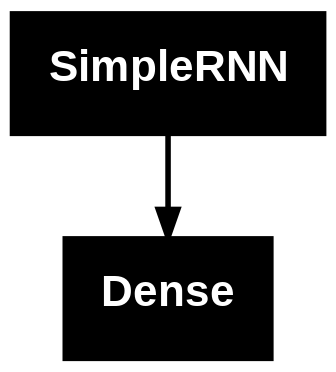

In [ ]:

keras.utils.plot_model(model_rnn)

In [ ]:

from statistics import mean

In [ ]:

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:
history.history

{'accuracy': [0.9304378032684326,
  0.9508870244026184,
  0.9514987468719482,
  0.951586127281189,
  0.951586127281189],
 'auc': [0.5741127729415894,
  0.506023108959198,
  0.5326891541481018,
  0.6196175217628479,
  0.6307041645050049],
 'fn': [522.0, 553.0, 554.0, 554.0, 554.0],
 'fp': [274.0, 9.0, 1.0, 0.0, 0.0],
 'loss': [0.3676668703556061,
  0.2513880431652069,
  0.21215717494487762,
  0.19453127682209015,
  0.18970611691474915],
 'val_accuracy': [0.9489688873291016,
  0.9510660767555237,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866],
 'val_auc': [0.5407140851020813,
  0.5482585430145264,
  0.5905663371086121,
  0.6461816430091858,
  0.6361329555511475],
 'val_fn': [135.0, 139.0, 139.0, 139.0, 139.0],
 'val_fp': [11.0, 1.0, 0.0, 0.0, 0.0],
 'val_loss': [0.28095972537994385,
  0.22037500143051147,
  0.20049254596233368,
  0.1899457722902298,
  0.18838472664356232]}

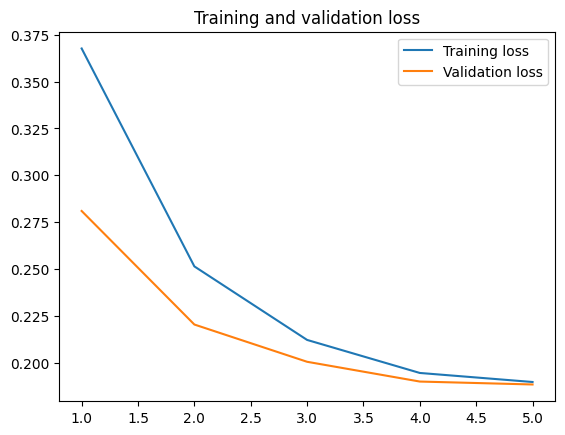

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


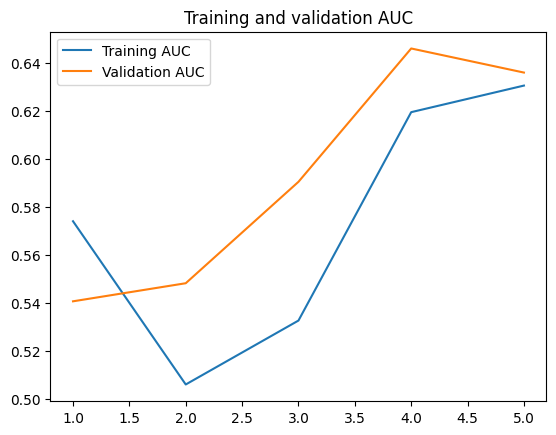

In [ ]:

auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.show()

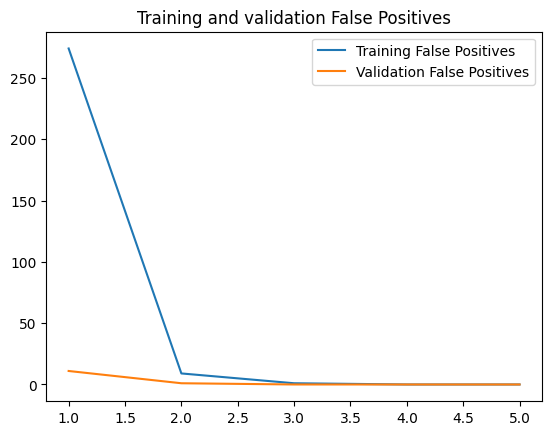

In [ ]:

fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives')
plt.legend()
plt.show()

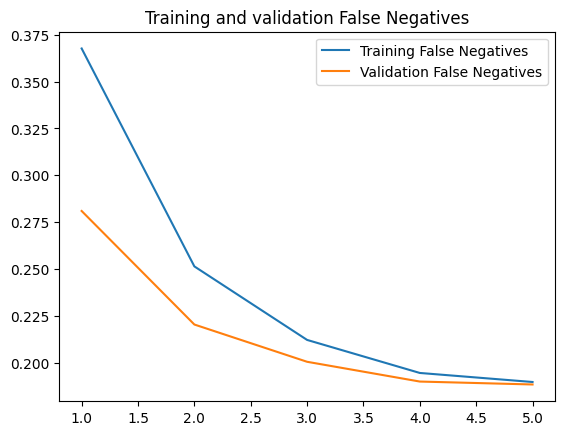

In [ ]:

fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives')
plt.legend()
plt.show()

In [ ]:

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:

history.history

{'accuracy': [0.9076358675956726,
  0.9076358675956726,
  0.9076358675956726,
  0.9076358675956726,
  0.9076358675956726],
 'auc': [0.646138608455658,
  0.6500058174133301,
  0.6457704305648804,
  0.644420862197876,
  0.6494100093841553],
 'fn': [554.0, 554.0, 554.0, 554.0, 554.0],
 'fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [0.29324474930763245,
  0.2930460572242737,
  0.292969673871994,
  0.2928510010242462,
  0.292640745639801],
 'val_accuracy': [0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866],
 'val_auc': [0.6534816026687622,
  0.6514187455177307,
  0.6464486122131348,
  0.6443223357200623,
  0.6485511660575867],
 'val_fn': [139.0, 139.0, 139.0, 139.0, 139.0],
 'val_fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.20005153119564056,
  0.19955772161483765,
  0.2018032819032669,
  0.20087875425815582,
  0.20187227427959442]}

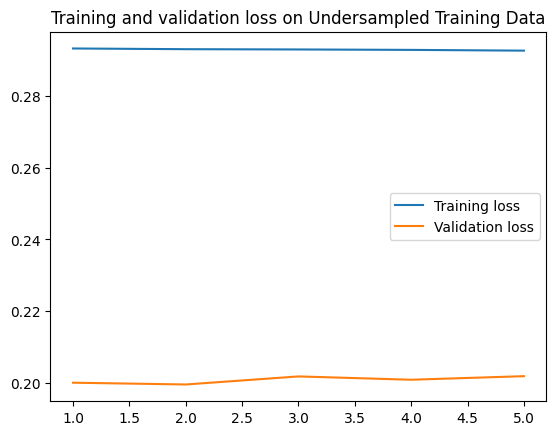

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss on Undersampled Training Data')
plt.legend()
plt.show()

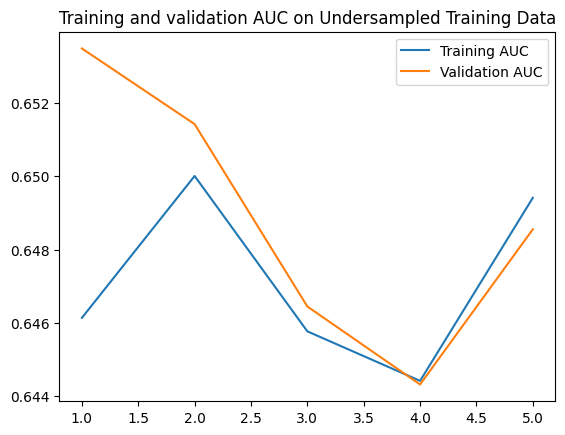

In [ ]:

auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC on Undersampled Training Data')
plt.legend()
plt.show()

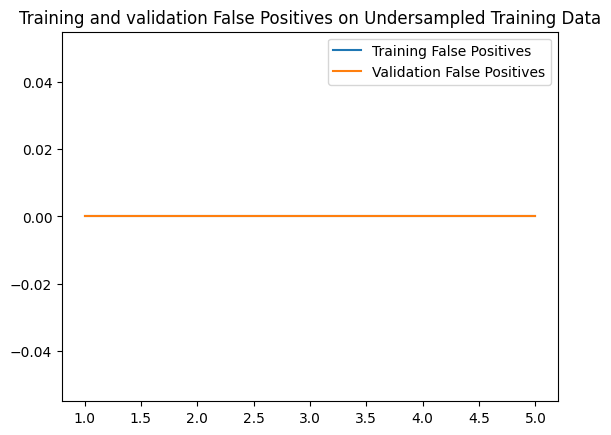

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives on Undersampled Training Data')
plt.legend()
plt.show()

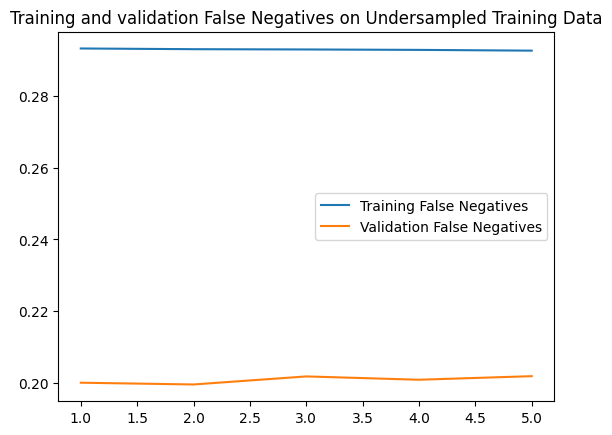

In [ ]:

fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives on Undersampled Training Data')
plt.legend()
plt.show()